In [1]:
!pip install albumentations

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/68/49/5e1c771294407bb25e6dbcf169aef5cffefcddf27b0176125a9b0af06a1e/torchvision-0.17.2-cp311-cp311-manylinux1_x86_64.whl.metadata
  Using cached torchvision-0.17.2-cp311-cp311-manylinux1_x86_64.whl.metadata (6.6 kB)
  Obtaining dependency information for torch==2.2.2 from https://files.pythonhosted.org/packages/c3/33/d7a6123231bd4d04c7005dde8507235772f3bc4622a25f3a88c016415d49/torch-2.2.2-cp311-cp311-manylinux1_x86_64.whl.metadata
  Using cached torch-2.2.2-cp311-cp311-manylinux1_x86_64.whl.metadata (25 kB)
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/6e/b5/15b3b36f298bcbc0be82a371ac744f4f5a10309ade0b8bbde286598dd612/filelock-3.13.4-py3-none-any.whl.metadata
  Using cached filelock-3.13.4-py3-none-any.whl.metadata (2.8 kB)
  Obtaining dependency information for fsspec 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 530.5 kB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 519.7 kB/s eta 0:00:00m eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 614.8 kB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 757.8 kB/s eta 0:00:00m eta 0:00:0136m0:00:18m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 797.6 kB/s eta 0:00:00m eta 0:00:010:00:05
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 851.1 kB/s eta 0:00:00m eta 0:00:010:00:02m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 982.7 kB/s eta 0:00:00 eta 0:00:01m0:00:04
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 459.9 kB/s eta 0:00:00m eta 0:00:010:00:13
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 1.1 MB/s eta 0:00:00m eta 0:00:010:00:04m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 1.2 MB/s eta 0:00:00 MB/s eta 0:

In [3]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import cv2
import numpy as np
from numpy.core.defchararray import join, mod
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import os
import torch
from torch._C import device
from torch.autograd.grad_mode import F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator
from PIL import Image
from torchvision import transforms as torchtrans  

In [5]:
labels_path = '/home/pc15/Lab9/Lab 9/archive(2) (1)/weapon_detection/train/labels'
imgs_path = '/home/pc15/Lab9/Lab 9/archive(2) (1)/weapon_detection/train/images'

In [8]:
device = torch.device("cpu") 
#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
class gun(Dataset):
    def __init__(self,imgs_path,labels_path):

        self.imgs_path = imgs_path
        self.labels_path = labels_path
        #from the path,made lists of images & labels' name
        self.img_name = [img for img in sorted(os.listdir(self.imgs_path))]
        self.label_name = [label for label in sorted(os.listdir(self.labels_path))]

    def __getitem__(self,idx):

        image_path = os.path.join(self.imgs_path,str(self.img_name[idx]))
        img = cv2.imread(image_path)
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = img_rgb/255
        img_res = torch.as_tensor(img_res).to(device)
        img_res = img_res.permute(2, 0, 1)
        
        label_name = self.img_name[idx][:-4] + "txt"
        label_path = os.path.join(self.labels_path,str(label_name))
        with open(label_path, 'r') as label_file:
            l_count = int(label_file.readline())
            box = []
            for i in range(l_count):
                box.append(list(map(int, label_file.readline().split())))

        target={}
        target["boxes"] = torch.as_tensor(box).to(device)
        area = []
        for i in range(len(box)):
           
            a = (box[i][2] - box[i][0]) * (box[i][3] - box[i][1])
            area.append(a)
        target["area"] = torch.as_tensor(area).to(device)
        labels = []
        for i in range(len(box)):
            labels.append(1)

        target["image_id"] = torch.as_tensor([idx]).to(device)
        target["labels"] = torch.as_tensor(labels, dtype = torch.int64).to(device)


        return img_res,target

    def __len__(self):
        return len(self.img_name)

In [9]:
def model(num):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(
        in_features, num)
    return model


def collate_fn(batch):
    return tuple(zip(*batch))


## Train session (not run it on inference)

In [10]:
gun_data = gun(imgs_path, labels_path)
data_load = DataLoader(gun_data, batch_size=5,
                       shuffle=True, num_workers=0, collate_fn=collate_fn)
num_class = 2
model = model(num_class)
model.to(device)
num_epoch = 10
param = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.SGD(param,lr=0.01,momentum=0.9)


/home/pc15/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pc15/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/pc15/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100.0%


In [11]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
backbone.body.conv1.weight 	 torch.Size([64, 3, 7, 7])
backbone.body.bn1.weight 	 torch.Size([64])
backbone.body.bn1.bias 	 torch.Size([64])
backbone.body.bn1.running_mean 	 torch.Size([64])
backbone.body.bn1.running_var 	 torch.Size([64])
backbone.body.layer1.0.conv1.weight 	 torch.Size([64, 64, 1, 1])
backbone.body.layer1.0.bn1.weight 	 torch.Size([64])
backbone.body.layer1.0.bn1.bias 	 torch.Size([64])
backbone.body.layer1.0.bn1.running_mean 	 torch.Size([64])
backbone.body.layer1.0.bn1.running_var 	 torch.Size([64])
backbone.body.layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
backbone.body.layer1.0.bn2.weight 	 torch.Size([64])
backbone.body.layer1.0.bn2.bias 	 torch.Size([64])
backbone.body.layer1.0.bn2.running_mean 	 torch.Size([64])
backbone.body.layer1.0.bn2.running_var 	 torch.Size([64])
backbone.body.layer1.0.conv3.weight 	 torch.Size([256, 64, 1, 1])
backbone.body.layer1.0.bn3.weight 	 torch.Size([256])
backbone.body.layer1.0.bn3.bias 	 torch.Size([25

In [54]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])


Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.01, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]}]


In [55]:
# Save model
TRAINED_MODEL_VERSION = "1.0a"
TRAINED_MODEL_FILENAME = "weapon_trained_model-"+TRAINED_MODEL_VERSION+".pt"
torch.save(model, TRAINED_MODEL_FILENAME)

## Load pre-trained model and inference

In [56]:
!ls -l

total 163044
drwxrwxr-x 5 asimasarwar asimasarwar      4096 Apr 18 10:29 'archive(3)'
-rw-rw-r-- 1 asimasarwar asimasarwar   1177414 Apr 18 16:52  faster-rcnn-guns-detection.ipynb
drwxrwxr-x 4 asimasarwar asimasarwar      4096 Apr 18 11:36  weapon_trained_model-1.0a
-rw-rw-r-- 1 asimasarwar asimasarwar 165761274 Apr 18 16:53  weapon_trained_model-1.0a.pt


In [58]:
# Load the model
# model = TheModelClass(*args, **kwargs)

LOAD_MODEL_VERSION = "1.0a"
LOAD_MODEL_FILENAME = "weapon_trained_model-"+LOAD_MODEL_VERSION+".pt"
LOAD_DIR = './'

cpu_device = torch.device("cpu")

# model.load_state_dict(torch.load(LOAD_DIR+LOAD_MODEL_FILENAME))
model= torch.load(LOAD_DIR+LOAD_MODEL_FILENAME, map_location=torch.device('cpu'))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [70]:
test_path = '/home/asimasarwar/Music/weapon detection/archive(3)/Images'
test_data = gun(test_path, labels_path)
img,tar = test_data[5]
input = []
input.append(img)
outputs = model(input)
test_data

In [60]:
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
outputs

[{'boxes': tensor([[157.3044,  95.1742, 167.1700, 104.0264],
          [ 80.3069,  95.2543, 158.8815, 151.8546],
          [ 60.1391, 121.7682,  74.2612, 154.5293],
          [151.9481,  94.3602, 168.4417, 112.2370],
          [ 76.0201, 102.9484, 100.2201, 146.0182],
          [ 89.9964, 105.3783, 130.0975, 142.3791],
          [129.2918,  40.1866, 167.3592, 116.1875],
          [124.6453,  34.6595, 238.5731,  58.2537],
          [122.7815, 136.4539, 146.8746, 160.0473],
          [232.3744,  83.3963, 256.6558, 130.7627],
          [136.7957,  62.5665, 151.0095,  88.5998],
          [129.7132,  45.5932, 149.0627, 108.5881],
          [ 70.7856, 117.2377, 101.7347, 155.1533],
          [ 98.1684, 109.4282, 126.3122, 157.6032],
          [172.2272,  93.0471, 184.4358, 107.0123],
          [126.2325, 144.2736, 145.2178, 156.6590],
          [175.0045,  95.7575, 183.5540, 105.6198],
          [241.5334,  78.3313, 256.3156,  94.3493],
          [134.0493,  41.3620, 157.6246,  90.3400],
   

In [71]:
import matplotlib.patches as patches
def apply_nms(orig_prediction, iou_thresh=None):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')


def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

Predicted


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

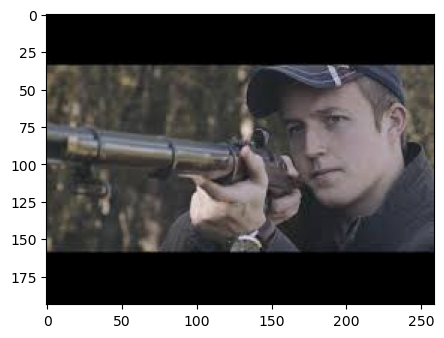

In [72]:
nms_prediction = apply_nms(outputs[0], iou_thresh=0.7)
print('Predicted')
plot_img_bbox(torch_to_pil(img), nms_prediction)


Ground true


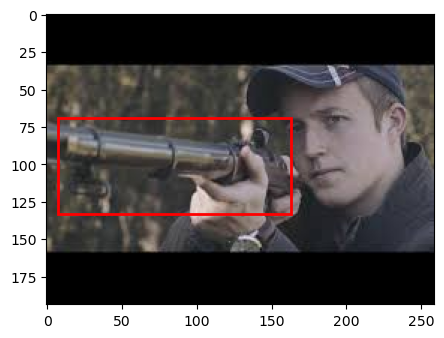

In [63]:
print("Ground true")
plot_img_bbox(torch_to_pil(img), tar)

let's try other types of guns

In [64]:
img,tar = test_data[4]
input = []
input.append(img)
outputs = model(input)
#outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
#outputs

Predicted


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

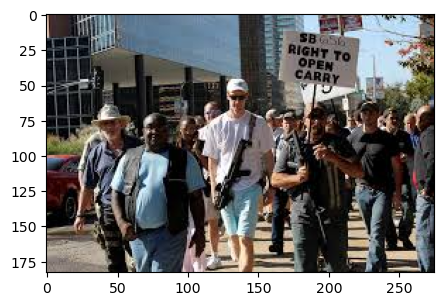

In [65]:
nms_prediction = apply_nms(outputs[0], iou_thresh=0.7)
print('Predicted')
plot_img_bbox(torch_to_pil(img), nms_prediction)

Predicted


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

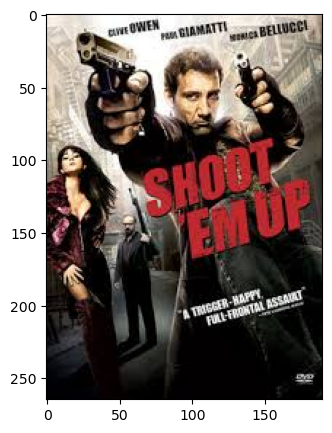

In [66]:
img,tar = test_data[10]
input = []
input.append(img)
outputs = model(input)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
nms_prediction = apply_nms(outputs[0], iou_thresh=0.7)
print('Predicted')
plot_img_bbox(torch_to_pil(img), nms_prediction)

Predicted


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

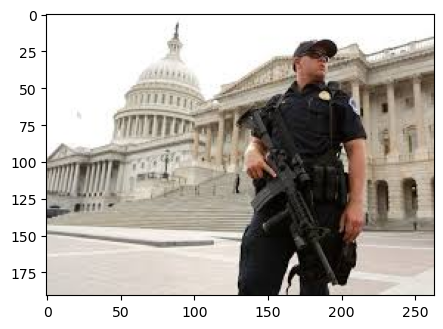

In [67]:
img,tar = test_data[19]
input = []
input.append(img)
outputs = model(input)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
nms_prediction = apply_nms(outputs[0], iou_thresh=0.7)
print('Predicted')
plot_img_bbox(torch_to_pil(img), nms_prediction)